In [1]:
from data_handling import *
from warnings import simplefilter
import spectral
import numpy as np
import pandas as pd
import pickle 

%load_ext tensorboard

In [2]:
import tensorflow as tf
from tensorflow import keras  # tf.keras
import matplotlib as mpl
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
spectral.settings.envi_support_nonlowercase_params = True
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
pd.options.plotting.backend = "plotly"
%matplotlib widget
root = get_root_folder("PC")
root_training = root + "/training"
root_references = root_training + "/references"

INFO:data_handling:Root folder set to D:\OneDriveFHNW\FHNW\EUT-P6bb-21HS-RS_M365 - General\captures


In [4]:
BANDS = np.round(np.linspace(900,1700,224),1);
RGB_BANDS = (81,131,181)

BAND_LOW = 8
BAND_HIGH = 210

PLOT_LABELS = {"index": "Wavelength [nm]", "value": "reflectance [1]", "variable": "pixel"}
COLUMN_NAMES = BANDS[BAND_LOW:BAND_HIGH]

background_samples = {}

In [5]:
##### Read Data
plastic_data = pd.read_csv("./raw_data/mixed_plastics.csv")
compost_data = pd.read_csv("./raw_data/mixed_compost.csv")
background_data = pd.read_csv("./raw_data/background.csv")

fulldata = np.concatenate((plastic_data, compost_data, background_data))
np.shape(fulldata)

(979210, 202)

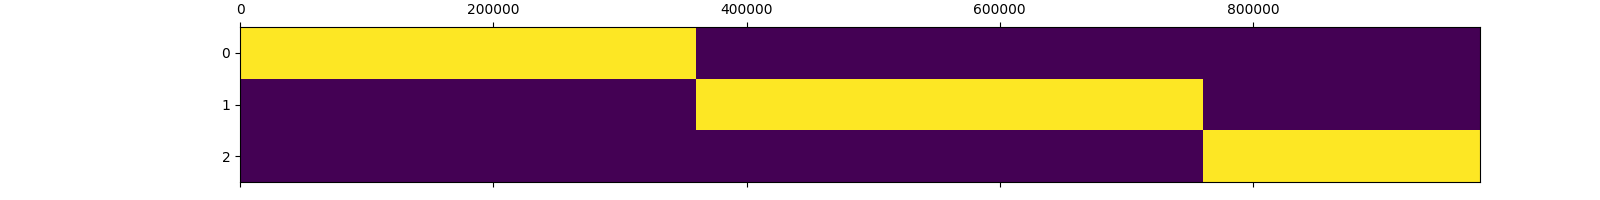

In [6]:
labels = np.zeros((len(plastic_data)+len(compost_data)+len(background_data),3))
labels[:len(plastic_data),0] = 1
labels[len(plastic_data):len(plastic_data)+len(compost_data),1] = 1
labels[len(plastic_data)+len(compost_data):,2] = 1

plt.matshow(labels.T, aspect='auto')

In [7]:
## Load eval data

plastic_data_eval = pd.read_csv("./raw_data/eval_plastics.csv")
compost_data_eval = pd.read_csv("./raw_data/eval_compost.csv")
background_data_eval = pd.read_csv("./raw_data/eval_bg.csv")

fulldata_eval = np.concatenate((plastic_data_eval, compost_data_eval, background_data_eval))
np.shape(fulldata_eval)

(90233, 202)

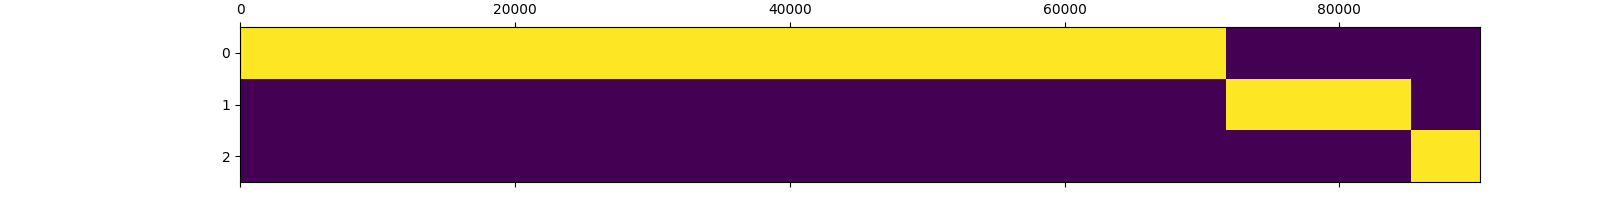

In [8]:
labels_eval = np.zeros((len(plastic_data_eval)+len(compost_data_eval)+len(background_data_eval),3))
labels_eval[:len(plastic_data_eval),0] = 1
labels_eval[len(plastic_data_eval):len(plastic_data_eval)+len(compost_data_eval),1] = 1
labels_eval[len(plastic_data_eval)+len(compost_data_eval):,2] = 1

plt.matshow(labels_eval.T, aspect='auto')

### No Preprocessing

In [9]:
#fulldata_snv = snv_transform(fulldata)
scaler = preprocessing.MinMaxScaler()
fulldata_scaled = scaler.fit_transform(fulldata)

# Save scaler for use when predicting plastics later
pickle.dump(scaler, open('scalers/scaler_no_transform.pkl', 'wb'))

In [10]:
scaler = pickle.load(open('scalers/scaler_no_transform.pkl', 'rb'))
fulldata_eval_scaled_no_snv = scaler.transform(fulldata_eval)

In [13]:
model_no_transform = keras.models.Sequential([
        keras.layers.Input(202),
        keras.layers.Dense(96, activation="relu"),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(48, activation="relu"),
        keras.layers.Dense(3, activation="softmax"),
    ])

model_no_transform.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 96)                19488     
                                                                 
 dropout_1 (Dropout)         (None, 96)                0         
                                                                 
 dense_4 (Dense)             (None, 48)                4656      
                                                                 
 dense_5 (Dense)             (None, 3)                 147       
                                                                 
Total params: 24,291
Trainable params: 24,291
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = 

In [14]:
import datetime

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S_no_transform")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
eval_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_no_transform.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=2e-3),
              metrics=["accuracy"],)

training_history = model_no_transform.fit(fulldata_scaled, labels, validation_data=(fulldata_eval_scaled_no_snv,labels_eval), epochs=100, callbacks=[tensorboard_callback, eval_callback], batch_size=512)

Epoch 1/100
1913/1913 [==============================] - 10s 5ms/step - loss: 0.8486 - accuracy: 0.5318 - val_loss: 0.4129 - val_accuracy: 0.9431
Epoch 2/100
1913/1913 [==============================] - 9s 5ms/step - loss: 0.5972 - accuracy: 0.8600 - val_loss: 0.3082 - val_accuracy: 0.9128
Epoch 3/100
1913/1913 [==============================] - 8s 4ms/step - loss: 0.4343 - accuracy: 0.8844 - val_loss: 0.2565 - val_accuracy: 0.9032
Epoch 4/100
1913/1913 [==============================] - 8s 4ms/step - loss: 0.3325 - accuracy: 0.8976 - val_loss: 0.2206 - val_accuracy: 0.9168
Epoch 5/100
1913/1913 [==============================] - 8s 4ms/step - loss: 0.2725 - accuracy: 0.9075 - val_loss: 0.1942 - val_accuracy: 0.9248
Epoch 6/100
1913/1913 [==============================] - 8s 4ms/step - loss: 0.2339 - accuracy: 0.9157 - val_loss: 0.1686 - val_accuracy: 0.9320
Epoch 7/100
1913/1913 [==============================] - 8s 4ms/step - loss: 0.2052 - accuracy: 0.9235 - val_loss: 0.1549 - val_a

In [15]:
model_no_transform.save('./models/model_no_transform')

INFO:tensorflow:Assets written to: ./models/model_no_transform\assets


### Smooth + SNV Transform

In [18]:
from scipy.signal import savgol_filter
fulldata_smoothed = savgol_filter(fulldata, window_length=15, polyorder=3,deriv=0)
fulldata_snv = snv_transform(fulldata_smoothed)
scaler = preprocessing.MinMaxScaler()
fulldata_snv_scaled = scaler.fit_transform(fulldata_snv)

# Save scaler for use when predicting plastics later
pickle.dump(scaler, open('scalers/scaler_snv.pkl', 'wb'))

In [19]:
scaler = pickle.load(open('scalers/scaler_snv.pkl', 'rb'))
fulldata_eval_smooth = savgol_filter(fulldata_eval, window_length=15, polyorder=3,deriv=0)
fulldata_eval_snv = snv_transform(fulldata_eval_smooth)
fulldata_eval_snv_scaled = scaler.transform(fulldata_eval_snv)

In [26]:
model_snv = keras.models.Sequential([
        keras.layers.Input(202),
        keras.layers.Dense(96, activation="relu"),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(48, activation="relu"),
        keras.layers.Dense(3, activation="softmax"),
    ])

model_snv.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 96)                19488     
                                                                 
 dropout_4 (Dropout)         (None, 96)                0         
                                                                 
 dense_13 (Dense)            (None, 48)                4656      
                                                                 
 dense_14 (Dense)            (None, 3)                 147       
                                                                 
Total params: 24,291
Trainable params: 24,291
Non-trainable params: 0
_________________________________________________________________


In [27]:
import datetime

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S_snv")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
eval_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_snv.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=2e-3),
              metrics=["accuracy"],)

training_history = model_snv.fit(fulldata_snv_scaled, labels, validation_data=(fulldata_eval_snv_scaled,labels_eval), epochs=100, callbacks=[tensorboard_callback, eval_callback], batch_size=512)

Epoch 1/100
1913/1913 [==============================] - 12s 6ms/step - loss: 0.5722 - accuracy: 0.7924 - val_loss: 0.8546 - val_accuracy: 0.6206
Epoch 2/100
1913/1913 [==============================] - 9s 5ms/step - loss: 0.3513 - accuracy: 0.8864 - val_loss: 0.7954 - val_accuracy: 0.6579
Epoch 3/100
1913/1913 [==============================] - 8s 4ms/step - loss: 0.3102 - accuracy: 0.8986 - val_loss: 0.7479 - val_accuracy: 0.6788
Epoch 4/100
1913/1913 [==============================] - 8s 4ms/step - loss: 0.2887 - accuracy: 0.9047 - val_loss: 0.7015 - val_accuracy: 0.6961
Epoch 5/100
1913/1913 [==============================] - 8s 4ms/step - loss: 0.2743 - accuracy: 0.9084 - val_loss: 0.6743 - val_accuracy: 0.7069
Epoch 6/100
1913/1913 [==============================] - 8s 4ms/step - loss: 0.2613 - accuracy: 0.9115 - val_loss: 0.6424 - val_accuracy: 0.7166
Epoch 7/100
1913/1913 [==============================] - 8s 4ms/step - loss: 0.2502 - accuracy: 0.9137 - val_loss: 0.6074 - val_a

In [28]:
model_snv.save('./models/model_snv')

INFO:tensorflow:Assets written to: ./models/model_snv\assets


### Smooth + Derivative

In [29]:
from scipy.signal import savgol_filter
fulldata_deriv = savgol_filter(fulldata, window_length=25, polyorder=2,deriv=1)
fulldata_snv = snv_transform(fulldata_deriv)
scaler = preprocessing.MinMaxScaler()
fulldata_snv_scaled = scaler.fit_transform(fulldata_snv)

# Save scaler for use when predicting plastics later
pickle.dump(scaler, open('scalers/scaler_deriv_snv.pkl', 'wb'))

In [30]:
scaler = pickle.load(open('scalers/scaler_deriv_snv.pkl', 'rb'))
fulldata_eval_deriv = savgol_filter(fulldata_eval, window_length=25, polyorder=2,deriv=1)
fulldata_eval_snv = snv_transform(fulldata_eval_deriv)
fulldata_eval_snv_scaled = scaler.transform(fulldata_eval_snv)

In [31]:
model_snv = keras.models.Sequential([
        keras.layers.Input(202),
        keras.layers.Dense(96, activation="relu"),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(48, activation="relu"),
        keras.layers.Dense(3, activation="softmax"),
    ])

model_snv.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 96)                19488     
                                                                 
 dropout_5 (Dropout)         (None, 96)                0         
                                                                 
 dense_16 (Dense)            (None, 48)                4656      
                                                                 
 dense_17 (Dense)            (None, 3)                 147       
                                                                 
Total params: 24,291
Trainable params: 24,291
Non-trainable params: 0
_________________________________________________________________


In [32]:
import datetime

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S_snv_deriv")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
eval_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_snv.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=2e-3),
              metrics=["accuracy"],)

training_history = model_snv.fit(fulldata_snv_scaled, labels, validation_data=(fulldata_eval_snv_scaled,labels_eval), epochs=100, callbacks=[tensorboard_callback, eval_callback], batch_size=512)

Epoch 1/100
1913/1913 [==============================] - 11s 5ms/step - loss: 0.7551 - accuracy: 0.7100 - val_loss: 0.3641 - val_accuracy: 0.9131
Epoch 2/100
1913/1913 [==============================] - 9s 5ms/step - loss: 0.3622 - accuracy: 0.8960 - val_loss: 0.2176 - val_accuracy: 0.9139
Epoch 3/100
1913/1913 [==============================] - 8s 4ms/step - loss: 0.2686 - accuracy: 0.9133 - val_loss: 0.1794 - val_accuracy: 0.8989
Epoch 4/100
1913/1913 [==============================] - 8s 4ms/step - loss: 0.2274 - accuracy: 0.9230 - val_loss: 0.1600 - val_accuracy: 0.9045
Epoch 5/100
1913/1913 [==============================] - 8s 4ms/step - loss: 0.1998 - accuracy: 0.9326 - val_loss: 0.1428 - val_accuracy: 0.9165
Epoch 6/100
1913/1913 [==============================] - 8s 4ms/step - loss: 0.1790 - accuracy: 0.9414 - val_loss: 0.1364 - val_accuracy: 0.9310
Epoch 7/100
1913/1913 [==============================] - 9s 5ms/step - loss: 0.1635 - accuracy: 0.9484 - val_loss: 0.1324 - val_a

In [33]:
model_snv.save('./models/model_snv_deriv')

INFO:tensorflow:Assets written to: ./models/model_snv_deriv\assets


In [8]:
model = keras.models.load_model("./models/model_no_transform/")

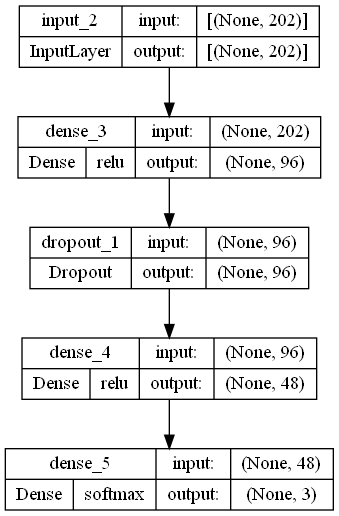

In [18]:
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)